# Problem set 2 (35 + 55 + 15 + 28 = 133 pts)

## Problem 1 (LU decomposition) 35 pts


### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

In [666]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
def band_lu(diag_broadcast, n, return_real_shape=False):
    m = len(diag_broadcast)
    if m not in [3, 5]:
      raise LookupError("Change diag vector size to 3 or 5")

    if n < m:
      print(f"Size of matrix {n} x {n} is less than the bandwidth {m} allows. The matrix is {m} x {m} now.")
      n = m

    if m == 3:
      a, d, b = diag_broadcast

      L = np.zeros((1, n-1))
      U = np.zeros((n, 2))

      dd_current = d
      U[0][0] += dd_current

      for i in range(1, n):
          if not dd_current:
              raise ZeroDivisionError("LU doesn't exist")

          bb_current = b / dd_current
          L[0][i-1] += bb_current

          dd_current = d - bb_current * a
          U[:, 0][i] += dd_current

      U[:n-1, 1] = a

      if return_real_shape:
          L = np.diag(L[0],  k=-1) + np.diag([1] * n)
          U = np.diag(U[:, 0]) + np.diag(U[:-1, 1], k=1)
      return L, U

    else:
      a, b, c, d, e = diag_broadcast
      delta = np.empty(n)
      alpha = np.empty(n-1)
      beta = np.empty(n-2)
      gamma = np.repeat(a, n-2)
      tetta = np.empty(n-1)

      delta[0] = c 
      alpha[0] = - d / c
      beta[0] = - e / c

      delta[1] = c - d * b / c
      alpha[1] = (e / c * b - d) / (c - d * b / c)
      beta[1] = - e / (c - d * b / c) 

      for i in range (2, n):
        delta[i] = c + (a * alpha[i-2] + b) * alpha[i-1] + a * beta[i-2]
        if i <= (n - 2):
          alpha[i] = - (d + (a*alpha[i-2] + b) * beta[i-1]) / delta[i]
          if i <= (n - 3):
            beta[i] = - e / delta[i]
      
      tetta[0] = b 
      tetta[1:n-1] = a * alpha[:n-2] + b
      if return_real_shape:
          L = np.diag(delta) +  np.diag(tetta, k=-1) + np.diag(gamma, k=-2)
          U = np.diag([1] * n) - np.diag(alpha, k=1) - np.diag(beta, k=2)
      else:
          alpha_prod, beta_prod, gamma_prod, tetta_prod = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)
          alpha_prod[:n-1] = alpha
          beta_prod[:n-2] = beta
          gamma_prod[:n-2] = gamma
          tetta_prod[:n-1] = tetta
          L = np.stack((gamma_prod, tetta_prod, delta))
          U = np.stack((-alpha_prod, -beta_prod))

    return L, U

### Note: keyword argument return_real_shape allows us to get the result with true shape (ones one diagonals)

In [667]:
from scipy.linalg import lu

In [668]:
L, U = band_lu([5, 6, 7], 5, return_real_shape=True)

In [669]:
L @ U

array([[6., 5., 0., 0., 0.],
       [7., 6., 5., 0., 0.],
       [0., 7., 6., 5., 0.],
       [0., 0., 7., 6., 5.],
       [0., 0., 0., 7., 6.]])

In [670]:
A = diags([8, 9, 10], [-1, 0, 1], shape=(5, 5)).toarray()
p, l, u = lu(A)
L, U = band_lu([8, 9, 10], 5, return_real_shape=True)
print("Count the error between handwritten and scipy's for m=3:\n")
print(p @ l @ u - L @ U)

Count the error between handwritten and scipy's for m=3:

[[ 0.  2.  0.  0.  0.]
 [-2.  0.  2.  0.  0.]
 [ 0. -2.  0.  2.  0.]
 [ 0.  0. -2.  0.  2.]
 [ 0.  0.  0. -2.  0.]]


In [523]:
L, U = band_lu([5, 8, 2, 3, 4], 5, return_real_shape=True)

In [ ]:
A = diags([5, 8, 2, 3, 4], [-2, -1, 0, 1, 2], shape=(5, 5)).toarray()
p, l, u = lu(A)
L, U = band_lu([5, 8, 2, 3, 4], 5, return_real_shape=True)
print(L.shape, U.shape)
print("Count the error between handwritten and scipy's for m=5:\n")
print(p @ l @ u - L @ U)

(5, 5) (5, 5)
Count the error between handwritten and scipy's for m=5:

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.77181094e-16
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  4.44089210e-16  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.44089210e-16
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.88178420e-16
   0.00000000e+00]]


In [ ]:
A = diags([5, 8, 2, 3, 4], [-2, -1, 0, 1, 2], shape=(100, 100)).toarray()
B = diags([1, 2, 3], [-1, 0, 1], shape=(100, 100)).toarray()

In [ ]:
self_times_3, self_times_5, scipy_times_3, scipy_times_5 = [], [], [], []

In [ ]:
for i in np.linspace(10, 500, 15):
  N = int(i)
  A = diags([1, 2, 3], [-1, 0, 1], shape=(N, N)).toarray()
  B = diags([5, 8, 2, 3, 4], [-2, -1, 0, 1, 2], shape=(N, N)).toarray()

  self_time_3 = %timeit -o -q band_lu([1, 2, 3], N)
  self_times_3.append(self_time_3.worst)

  self_time_5 = %timeit -o -q band_lu([5, 8, 2, 3, 4], N)
  self_times_5.append(self_time_5.worst)

  scipy_time_3 = %timeit -o -q lu(A)
  scipy_times_3.append(scipy_time_3.worst)

  scipy_time_5 = %timeit -o -q lu(B)
  scipy_times_5.append(scipy_time_5.worst)

In [ ]:
n = [int(n) for n in list(np.linspace(10, 500, 15))]

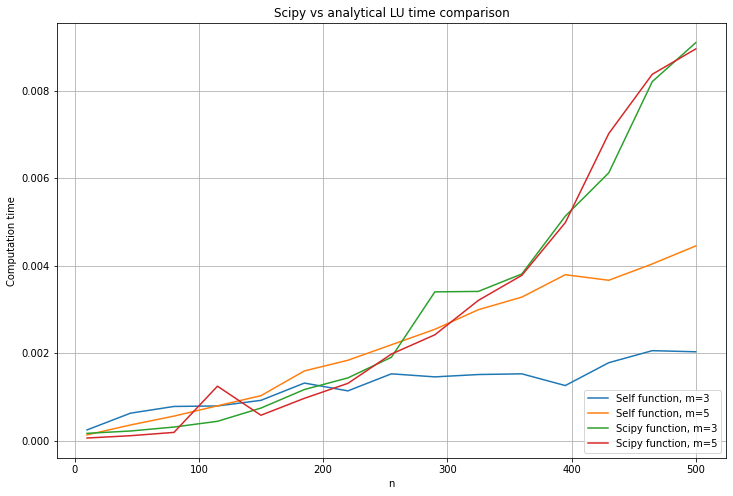

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(n, self_times_3, label = 'Self function, m=3')
plt.plot(n, self_times_5, label = 'Self function, m=5')
plt.plot(n, scipy_times_3, label = 'Scipy function, m=3')
plt.plot(n, scipy_times_5, label = 'Scipy function, m=5')

plt.legend(loc = 'lower right')

plt.grid(True)

plt.ylabel("Computation time")
plt.xlabel("n")
plt.title("Scipy vs analytical LU time comparison")
plt.show()

##### So, the band_lu functions grows like O(n), while the scipy function grows faster. What we know is that band_lu knows that it's dealing with particular type of matrices, and all the loops inside of it are single loops from 1 to n. 

##### We can't speculate on the mechanics inside the scipy functions, it might have simplification/pattern detection mechanics, but it is defenately slower in dynamics.

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

## Without pivoting

$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix} = 
LU = 
\begin{pmatrix}
1 & 0 & 0\\
l_1 & 1 & 0 \\
0 & l_2 & 1
\end{pmatrix}
\begin{pmatrix}
u_1 & 1 & 0\\
0 & u_2 & 1 \\
0 & 0 & u_3
\end{pmatrix}
$

Let's find explicit formulas for each of unknown elements of the matrices $L$ and $U$.

$u_1 \times 1 = a_{11} = \varepsilon$

$u_1 \times l_1 = 1$ => $l_1 = \frac{1}{\varepsilon}$

$l_2 \times u_2 = a_{32} = 1$ => $l_2 = \frac{1}{u_2}$

$a_{22} = 1 = u_2 \times 1 + l_1 \times 1$ => $u_2 = 1 - l_1 = 1 - \frac{1}{\varepsilon}$

$l_2 = \frac{1}{1 - \frac{1}{1-\varepsilon}} = \frac{\varepsilon - 1}{\varepsilon}$

$a_{23} = 1 = l_2 + u_3$ => $u_3 = 1 - l_2 = - \frac{1}{\varepsilon - 1}$

So, 

$A = LU = 
\begin{pmatrix}
1 & 0 & 0\\
\frac{1}{\varepsilon} & 1 & 0 \\
0 & \frac{\varepsilon - 1}{\varepsilon} & 1
\end{pmatrix}
\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1 - \frac{1}{\varepsilon} & 1 \\
0 & 0 & - \frac{1}{\varepsilon - 1}
\end{pmatrix}$

$\varepsilon$ can't equal 0 or 1 for all the terms of the decomposition to exist. Therefore, we need to use pivoting to avoid those kinds of terms. 

## With pivoting

Now, we need to permute the rows of the matrix $A$ in a manner that maximizes $a_{11}$, which we divide over.

So, the desired matrix looks like this:

$A = PLU$ 

Let $P = \begin{pmatrix}
0 & 1 & 0 \\
0 & 0 & 1\\
1 & 0 & 0
\end{pmatrix}$ =>


$A = \begin{pmatrix}
1 & 1 & 1 \\
0 & 1 & 1\\
\varepsilon & 1 & 0\\
\end{pmatrix} = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0\\
l_3 & l_2 & 1
\end{pmatrix}
\begin{pmatrix}
u_1 & u_4 & 1 \\
0 & u_2 & u_5\\
0 & 0 & u_3
\end{pmatrix} = 
\begin{pmatrix}
u_1 & u_4 & 1 \\
0 & u_2 & u_5\\
u_1 l _3 & u_2 l_2 + u_4 l_3 & u_5 l_2 + u_3 + l_3
\end{pmatrix}$ 


$u_1 = u_4 = u_2 = 1$

$l_3 = \varepsilon$

$l_2 = 1 - \varepsilon$

$u_5 = 1$

$u_3 =  - \varepsilon - (1 - \varepsilon) = -1$

So, 

$L = \begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0\\
\varepsilon & 1 - \varepsilon & 1\\
\end{pmatrix}$

$U = \begin{pmatrix}
1 & 1 & 1 \\
0 & 1 & 1\\
0 & 0 & - 1\\
\end{pmatrix}$

Now we avoided dividing over epsilon, which allows epsilon to be arbitary

### LU can fail with small enough $\varepsilon$, because
In order for LU decomposition to be stable, we need to make sure that the floating point arithmetic specifics didn't result into exceeding the calculation offset accuracy. Floating point numbers with large mantissa are very unreable in this situation.

### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

##1.
From now on let's work with the expanded matrix of the equation.

\begin{bmatrix} A_{11} & A_{12} & f_1\\ A_{21} & A_{22} & f_2\end{bmatrix}

Let's eliminate $A_{21}$. Let $r_1$ and $r_2$ be the rows of the matrix. From now on, $r_2 = r_2 -  A_{21} A_{11}^{-1} r_1$ (i.e. we eliminate the first row multiplied by $A_{21} A_{11}^{-1}$ from the left side).

Therefore, we have

$$
\begin{bmatrix} A_{11} & A_{12}\\ 0 & A_{22} - A_{21} A_{11}^{-1} A_{12} \end{bmatrix} \begin{bmatrix}u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix}f_1 \\ f_2 - A_{21} A_{11}^{-1} f_1\end{bmatrix}
$$

Thus, we conclude, that:

$\hat{f_2} = f_2 - A_{21} A_{11}^{-1} f_1$

and

$S = A_{22} - A_{21} A_{11}^{-1} A_{12}$

##2. 
For us in order to use Schur complement, we first need to construct a block matrix from the given ones.

$M = \begin{bmatrix} I & -B \\ A & X \end{bmatrix}$

In order to find Schur decomposition with respect to a particular block, we need this block to be invertible. That leads us to an idea to find Schur complement with respect to $X$. Since $X$ is non-singulare\, we can invert it.

Let's use a formula for Schur complement from [here](https://en.wikipedia.org/wiki/Schur_complement):

$S(M, X) = I + B X^{-1}A$

Let's go back to the formula we need to prove:

$\det(X+BA) = \det(X)\det(I+BX^{-1}A) \Leftrightarrow det(M) = \det(X)\det(S(M, X))$

The latter is the property of Schur complement. So, we proved the statement by the requested property.



## 3.


We need to consider two matrices:

$M_1 = \begin{bmatrix} I_m & F \\ G & I_m \end{bmatrix}$

$M_2 = \begin{bmatrix} I_n & G \\ F & I_n \end{bmatrix}$

And we need to proof that $\det{M_1} = \det{M_2}$

$\det{M_{1}} = \det(I_m) \det(S(M_1, I_m)) = \det(I_m) \det(I_m - GF) = \det(I_m - GF)$

$\det{M_{2}} = \det(I_n) \det(S(M_2, I_n) = \det(I_n) \det(I_n - FG) = \det(I_n - FG)$

**[Sylvester's determinant](https://en.wikipedia.org/wiki/Determinant#Sylvester's_determinant_theorem)** theorem states that:

$\det(I_m + BA) = \det(I_n + AB)$ for $A \in \mathbb{R}^{n \times m}$ and $B \in \mathbb{R}^{m \times n}$

Let $BA = - GF$ and $AB = - FG$, therefore we proved that $\det(I_m - GF) = \det(I_n - FG)$

### 4. Efficient implementation of LU decomposition (10 pts)

In the lecture we provide naive implementation of LU factorization with loops and elementwise update of factors. In this subproblem we ask you to provide more efficient implementation of LU factorization and explain how you derive this implementation (main ideas and how you use them in this particular case). 
- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 
- (4 pts) Implement the presented approach to speed up LU 
- (1 pts) Illustrate numerically that your implementation is correct
- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.
- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

NumPy or JAX are both ok in this subproblem, but please use the single library for all implementations. 

##1.
First let's revisit the naive implementation from the lecture (seeking what to imporve and also for comparing purposes)

In [574]:
import jax.numpy as jnp
import jax

def naive_LU_decomposition(matrix):
    n = matrix.shape[0]
    L = jnp.zeros((n, n))
    U = jnp.zeros((n, n))
    for k in range(n): #Eliminate one row   
        L = jax.ops.index_update(L, jax.ops.index[k, k], 1)
        for i in range(k+1, n):
            L = jax.ops.index_update(L, jax.ops.index[i, k], matrix[i, k] / matrix[k, k])
            for j in range(k+1, n):
                matrix = jax.ops.index_add(matrix, jax.ops.index[i, j], -L[i, k] * matrix[k, j])
        for j in range(k, n):
            U = jax.ops.index_update(U, jax.ops.index[k, j], matrix[k, j])
    return L, U

The main idea i'd like to propose is computing LU using dot products of vectors already computed in L and U

## 2.

In [563]:
def LU_decomposition(A):
    L = np.zeros_like(A)
    U = np.zeros_like(A)
    N = A.shape[0]

    for k in range(N):
        L[k, k] = 1
        U[k, k] = A[k, k] - L[k, :k] @ U[:k, k]
        for j in range(k+1, N):
            U[k, j] = A[k, j] - L[k, :k] @ U[:k, j]
        for i in range(k+1, N):
            L[i, k] = (A[i, k] - L[i, :k] @ U[:k, k]) / U[k, k]

    return L, U

## 3.

In [564]:
A = np.random.rand(10, 10)

In [565]:
L, U = LU_decomposition(A)

In [567]:
np.mean(A - L @ U)

8.028300246820663e-17

## 4.

In [693]:
def time_the_computation(function, n):
    A = np.random.rand(n, n)
    global f
    f = function
    time = %timeit -oq f(A)
    return time.best

In [694]:
from tqdm import tqdm_notebook

In [695]:
naive_LU_times = [time_the_computation(naive_LU_decomposition, i) for i in tqdm_notebook(range(2, 25))]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [696]:
my_LU_times = [time_the_computation(LU_decomposition, i) for i in tqdm_notebook(range(2, 25))]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [697]:
from scipy.linalg import lu

In [698]:
scipy_LU_times = [time_the_computation(lu, i) for i in tqdm_notebook(range(2, 25))]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [700]:
n_range = list(range(2, 25))

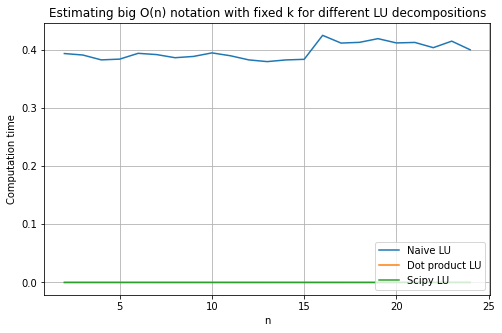

In [701]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(n_range, naive_LU_times, label = 'Naive LU')
plt.plot(n_range, my_LU_times, label = 'Dot product LU')
plt.plot(n_range, scipy_LU_times, label = 'Scipy LU')

plt.legend(loc = 'lower right')

plt.grid(True)

plt.ylabel("Computation time")
plt.xlabel("n")
plt.title("Estimating big O(n) notation with fixed k for different LU decompositions")
plt.show()

## 5.
Well, it seems like good old double loop is slow as usual, where as escaping it somehow makes the running time better. One could also try detect some signs of sparsity to reduce the running time (if possible).

## Problem 2 (eigenvalues)  55 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

## 1.
1) $A$ is normal, therefore $AA^{*} = A^{*}A$

Also, since $A$ is normal, we could achieve a given eigendecomposition:

$A = U \Lambda U^{*}$

We've got real eigenvalues and we need to proof $A = A^{*}$. Since they are real, $\Lambda = \Lambda^{*}$ also holds.

Thus, $A^{*} = (U \Lambda U^{*})^{*} = U^{*} \Lambda^{*} U = U \Lambda U^{*} = A$, or $A^{*} = A$, which we needed to proof.

2) We have $|\lambda|$ = 1 and need to proof that $A$ is now unitary, or $AA^{*} = A^{*}A = I$.

Again, since $A$ is normal, we could achieve a given eigendecomposition:

$A = U \Lambda U^{*}$

Thus, $AA^{*} = U \Lambda U^{*} U \Lambda^{*} U^{*} = U \Lambda \Lambda^{*} U^*$

Now, $\Lambda \Lambda^{*} = diag(|\lambda_1|, |\lambda_2|, ... |\lambda_n|) = I_n$. This means that $AA^{*} = I$, so we proved.

##2.

So we need to solve $\det{(J(\varepsilon) - \Lambda I)} = 0$

Let's compute the left part:

$\det{(J(\varepsilon) - \lambda' I)} = (\lambda - \Lambda_0)^n + (-1)^{n+1} \varepsilon = 0$

Therefore, 

$\lambda - \Lambda = \sqrt[n]{(-1)^{n+1} \varepsilon} =  \sqrt[n]\varepsilon$

Well, since $0$ numerically is never realy $0$, but some value close to $0$, the n-th root of this value would be very close to $1$, which will create an eigenvalue error of $1$.

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

## 1.

In [ ]:
import numpy as np 
from scipy.sparse import issparse, csr_matrix
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
  rows, cols = G.shape
  if issparse(G):
      nonzero_row, nonzero_col = G.nonzero()
      data = G.data
      col_sum = G.sum(axis=0)
      col_normalized = np.array(1/col_sum)[0]
      new_data = np.zeros(data.shape)
      for i, item in enumerate(nonzero_col):
          new_data[i] = col_normalized[item]
      return csr_matrix((new_data, (nonzero_row, nonzero_col)), shape=(G.shape[0], G.shape[0]))
  else:
      A = np.zeros((rows, cols))
      A, G = np.transpose(A), np.transpose(G)
      for i in range(rows):
          A[i,:] = G[i, :]/np.sum(G[i, :]) if np.any(G[i, :]) else np.zeros(len(G[i, :]))
      A, G = np.transpose(A), np.transpose(G)
  return A

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

## 2.

![graph[1].png](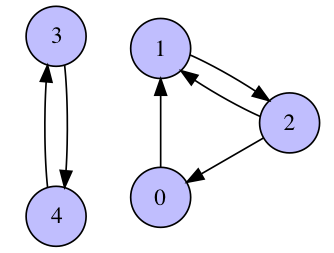)

Recreate the adjacency matrix and compute the pagerank matrix using our function:

In [ ]:
A = np.array([[0, 0, 1, 0, 0],
              [1, 0, 1, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0]])

In [ ]:
A_rank = pagerank_matrix(A)

In [ ]:
A_rank

array([[0. , 0. , 0.5, 0. , 0. ],
       [1. , 0. , 0.5, 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. , 0. ]])

Let's create characteristic polynomial:
$$
\det{\begin{pmatrix}
-\lambda & 0 & 0.5 & 0 & 0\\
1 & -\lambda & 0.5 & 0 & 0\\
0 & 1 & -\lambda & 0 & 0\\
0 & 0 & 0 &-\lambda & 1\\
0 & 0 & 0 & 1 & -\lambda
\end{pmatrix}} = - \lambda (1-\lambda)^2(\lambda + 1)^2
$$ 

Thus, the $\lambda_{max} = 1$, it's multiplicity equals 2

## 3.

In [ ]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
import numpy as np

def power_method(A, x0, num_iter): # 5 pts
    x_i = x0
    res = np.empty(num_iter)
    for i in range(num_iter): 
        x_i = A @ x_i
        x_i = x_i / np.linalg.norm(x_i)
        l = np.dot(A @ x_i, x_i)
        res[i] = np.linalg.norm(A @ x_i - l * x_i)
    return x_i, l, res

Let's check correctness using the proposed matrix:

In [ ]:
x, l, res = power_method(np.array([[2,-1], [-1, 2]]), np.random.rand(2), 100)

In [ ]:
l

2.9999999999999996

So, we do get the approximately right maximum eigenvalue.

* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

## 4.

In [ ]:
A = np.array([[0, 0, 1, 0, 0],
              [1, 0, 1, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0]])
A_rank = pagerank_matrix(A)
x0 = np.random.rand(5)
n = 100
x, l, res = power_method(A_rank, x0, n)

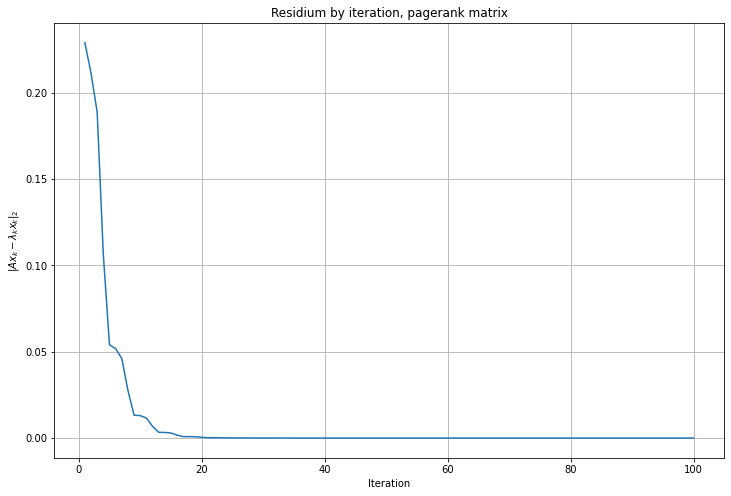

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(list(range(1, n+1)), res)

plt.grid()

plt.ylabel("$\|Ax_k - \lambda_k x_k\|_2$")
plt.xlabel("Iteration")
plt.title("Residium by iteration, pagerank matrix")
plt.show()

So, we see that the method doesn't realy continue after some constant error. This is because the power method assumes that there is one particular eigenvalue that is strictly larger in modulus than all the other eigenvalues. 

This adds upp to the fact that we seek for an eigenvector associated with this particular value, but in case of pagerank matrix there are two maximum eigenvalues: $1$ and $-1$.

##5.

Construct new adjacency matrix with vertex 4 now connected to itself:

In [ ]:
A = np.array([[0, 0, 1, 0, 0],
              [1, 0, 1, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 1]])
A = pagerank_matrix(A)
x, l, res = power_method(A, np.random.rand(5), 100)

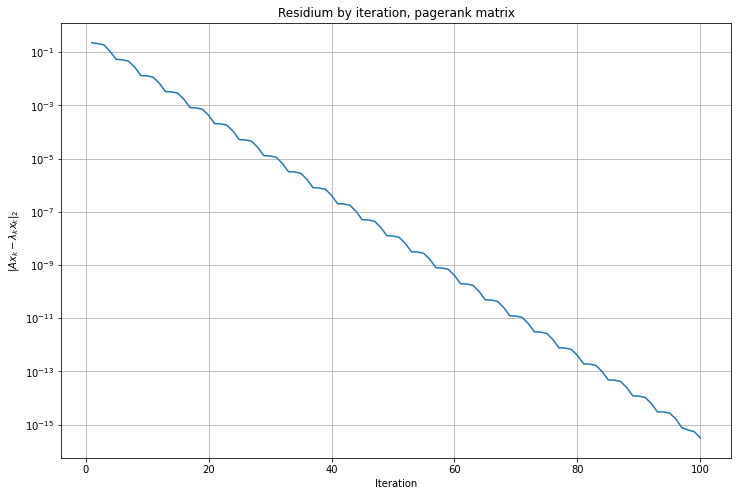

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.semilogy(list(range(1, n+1)), res)

plt.grid(True)

plt.ylabel("$\|Ax_k - \lambda_k x_k\|_2$")
plt.xlabel("Iteration")
plt.title("Residium by iteration, pagerank matrix")
plt.show()

In [ ]:
l

1.0

Well, now we see that the error decreases at a constant logarithmic pace with each iteration. Let's assume we might not yet now how this trick helped us. And also the eigenvalue is right, which is nice.

Now let's create 10 random inital guess vectors (which form a matrix) and plot each.

In [ ]:
random_guesses = np.random.rand(10, 5)
results = []
for x0 in random_guesses:
  _, _, res = power_method(A, x0, 100)
  results.append(res)

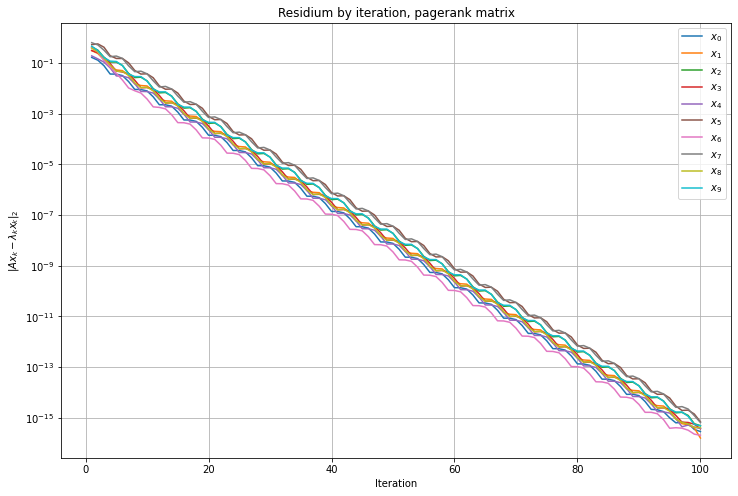

In [ ]:
plt.figure(figsize=(12,8))

plt.semilogy(list(range(1, n+1)), results[0], label = '$x_{0}$')
plt.semilogy(list(range(1, n+1)), results[1], label = '$x_{1}$')
plt.semilogy(list(range(1, n+1)), results[2], label = '$x_{2}$')
plt.semilogy(list(range(1, n+1)), results[3], label = '$x_{3}$')
plt.semilogy(list(range(1, n+1)), results[4], label = '$x_{4}$')
plt.semilogy(list(range(1, n+1)), results[5], label = '$x_{5}$')
plt.semilogy(list(range(1, n+1)), results[6], label = '$x_{6}$')
plt.semilogy(list(range(1, n+1)), results[7], label = '$x_{7}$')
plt.semilogy(list(range(1, n+1)), results[8], label = '$x_{8}$')
plt.semilogy(list(range(1, n+1)), results[9], label = '$x_{9}$')
plt.legend(loc = 'upper right')

plt.grid(True)

plt.ylabel("$\|Ax_k - \lambda_k x_k\|_2$")
plt.xlabel("Iteration")
plt.title("Residium by iteration, pagerank matrix")
plt.show()

The result depends on $x_0$, because the quality of the method is higher when this vector is closer to the direction of vector assosiated with those values. 

This parameter of the initial vector seems to influence the initial error offset.

## 6.
Now let's modify our pagerank matrix and include the damping factor (taking the initial matrix, without loop)

In [ ]:
A = np.array([[0, 0, 1, 0, 0],
              [1, 0, 1, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0]])

A = pagerank_matrix(A)
d = .97
A = d * A + (1 - d) / A.shape[0] * np.ones((A.shape[0], A.shape[0]))

In [ ]:
x, l, res = power_method(A, np.random.rand(A.shape[0]), 100)

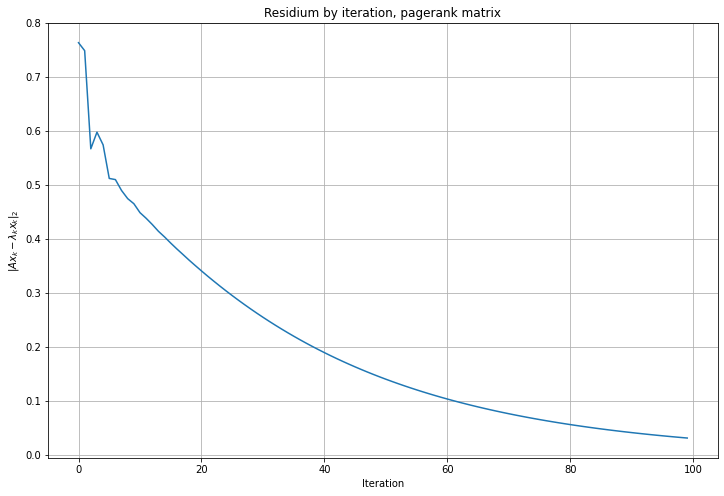

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(list(range(100)), res)

plt.grid(True)

plt.ylabel("$\|Ax_k - \lambda_k x_k\|_2$")
plt.xlabel("Iteration")
plt.title("Residium by iteration, pagerank matrix")
plt.show()

##7
For second largest value, let's use a built-in function (since power method only finds first largest).

In [ ]:
sorted(abs(np.linalg.eigvals(A)))[-2]

0.9700000000000002

Thus, the damping factor is the second largest eigenvalue. Actually, the pagerank matrix has two eigenvalues equal 0.97 in modulus, which correspond to the verticies 3 and 4. 

Since they are isolated, we could create a seperate adjacency matricies for them. Or, even better, we could study them as a Markov chain, and the probability of transition between the nodes of the chain equals the dampling factor $d$. 

We could represent this system as a matrix $M$ and calculate the evolution of it after $k$ steps, finding $k$-th degree of this matrix:

$M =\begin{bmatrix} 0 & d \\ d & 0 \end{bmatrix} = P \Lambda P^{-1}$

Since the PageRank metric doesn't need direct probabilities at each step, we pay attention only to $\Lambda$, which, in this case, one could check, equals $diag(d, -d)$ 

##8.
Let's recreate all the matrices and write the function. 

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

A = np.array([[0, 0, 1, 0, 0],
              [1, 0, 1, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0]])

A = pagerank_matrix(A)
A_sparse = csr_matrix(A)

In [ ]:
d = .97

In [ ]:
def pagerank_matvec(A, d, x): # 2 pts

    A_n = A.shape[0]
    x_n = x.shape[0]
    x1 = d * A @ x
    x2 = (1 - d) * np.ones(x_n) * np.sum(x) / A_n 
    
    return x1 + x2

Check correctness of the function by substracting the function's result from naive expression:

In [ ]:
pagerank_matvec(A_sparse, d, np.array([1,2,3,4,5])) - (d * A @ np.array([1,2,3,4,5]) + (1 - d) / A.shape[0] * np.ones((A.shape[0], A.shape[0])) @ np.array([1,2,3,4,5]))

array([0., 0., 0., 0., 0.])

## 9.
Now let's compare the evaluation times for $10000 \times 10000$

In [ ]:
G = np.random.choice([0, 1], size=(10000, 10000), p=[0.999999, 0.000001])

In [ ]:
A = pagerank_matrix(G)

In [ ]:
A_sparse = csr_matrix(A)

In [ ]:
x0 = np.random.rand(10000)
d = .93

%timeit pagerank_matvec(A_sparse, d, x0)

The slowest run took 6.29 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 131 µs per loop


In [ ]:
%timeit d * A @ x0 + (1 - d) / A.shape[0] * np.ones((A.shape[0], A.shape[0])) @ x0

1 loop, best of 3: 448 ms per loop


So we see that our trick did some progress indeed

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

## 10.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/'
/content/drive/MyDrive/Colab Notebooks


In [ ]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

Density of the adjacency matrix is:

In [ ]:
G.nnz / G.shape[0] ** 2

4.4986518152305776e-05

In [ ]:
G = G.transpose().tocsr()
G.data = np.ones(G.data.shape)
authors_sums = G.sum(axis=0)

In [ ]:
authors_sums = np.array(G.sum(axis=0))[0]

In [ ]:
authors_sums

matrix([[  0.,  18., 335., ...,  11.,   0.,   0.]])

In [ ]:
import pandas as pd

df = pd.DataFrame({"citations": np.array(authors_sums)[0], "author": authors})

Pairs (# of "citations", name) for top 10 authors are:

In [ ]:
df.sort_values('citations', ascending=False)[:10].author

1625973     Wei Wang
1679237     Yang Liu
1626092    Wei Zhang
897019     Lei Zhang
896968      Lei Wang
1625698       Wei Li
791433      Jun Wang
1625737      Wei Liu
791560     Jun Zhang
1677881    Yan Zhang
Name: author, dtype: object

In [ ]:
nonzeros_rows, nonzeros_cols = G.nonzero()

In [ ]:
from scipy.sparse import csr_matrix

n = len(nonzeros_rows)
G_prime = csr_matrix((np.ones(n), (nonzeros_rows, nonzeros_cols)), shape=G.shape)

In [ ]:
G_prime_pagerank = pagerank_matrix(G_prime)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Stochastic matrix is identified by its column sums being all ones (in our case also zeros, in case if a document doesn't refer to anyone), so let's check it:

In [ ]:
np.array(G_prime_pagerank.sum(axis=0))

array([[0., 1., 1., ..., 1., 0., 0.]])

## 11.

In [ ]:
import scipy

In [ ]:
import numpy as np

def power_method(A, x0, num_iter): # 5 pts
    x_i = x0
    res = np.empty(num_iter)
    for i in range(num_iter): 
        x_i = A @ x_i
        x_i = x_i / np.linalg.norm(x_i)
        l = np.dot(A @ x_i, x_i)
        res[i] = np.linalg.norm(A @ x_i - l * x_i)
    return x_i, l, res

In [ ]:
import scipy.sparse.linalg

In [ ]:
d = .85
L = scipy.sparse.linalg.LinearOperator(G_prime_pagerank.shape, matvec=lambda x, A=G_prime_pagerank, d=d: pagerank_matvec(G_prime_pagerank, d, x))

##12.

In [ ]:
x0 = np.ones(G_prime_pagerank.shape[0])

In [ ]:
x, l, res = power_method(L, x0, 100)

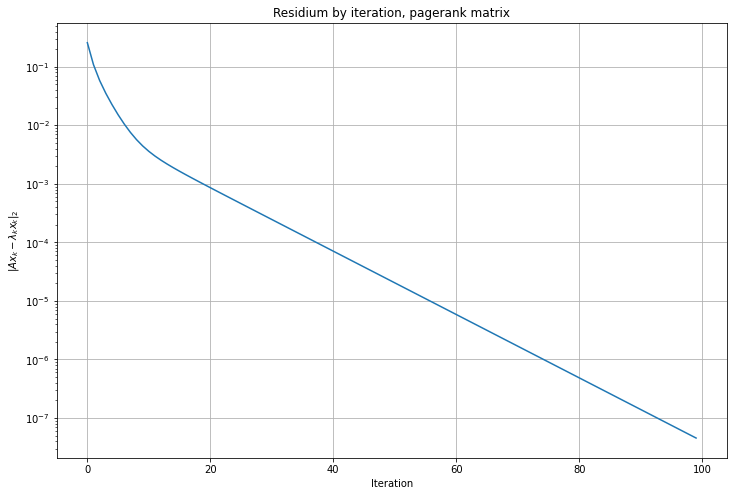

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.semilogy(list(range(100)), res)

plt.grid(True)

plt.ylabel("$\|Ax_k - \lambda_k x_k\|_2$")
plt.xlabel("Iteration")
plt.title("Residium by iteration, pagerank matrix")
plt.show()

## 13.


So x now is the vector, each component of which simply represents the rating of each author. So let's just analyse the authors:

In [ ]:
import pandas as pd

df = pd.DataFrame({"rating": x, "author": authors})

In [ ]:
df.sort_values('rating', ascending=False)[:10].author

334728       David E. Goldberg
1304778        Richard M. Karp
745295        John E. Hopcroft
151524        Azriel Rosenfeld
1330562       Ronald L. Rivest
108524            Anil K. Jain
1516121           Takeo Kanade
66090            Alfred V. Aho
1313064    Robert Endre Tarjan
505969           Gerard Salton
Name: author, dtype: object

Conclusion: the initial top-10 of the authors seemed to consider pure citations without their value, so we ranked top 10 maybe some Chinise scam-scientists (?).

But now we've got a true ranking, and the top 1 guy seems to have a lot of citations and even jis Hirsch index is high.

### 3. QR algorithm (10 pts)

* Implement QR-algorithm without shifting. Prototype of the function is given below

In [ ]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    Ak = A_init
    convergence = np.zeros(num_iter)
    for i in range(num_iter):
        Q, R = np.linalg.qr(Ak)
        Ak = R @ Q
        convergence[i] = np.amax(abs(R))
    return Ak, convergence

In [ ]:
A = np.random.rand(5, 5)

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [ ]:
from scipy.sparse import diags

A = diags([-1, 2, -1], [-1, 0, 1], shape=(11, 11)).toarray()

In [ ]:
Ak, convergence = qr_algorithm(A, 400)

In [ ]:
abs(np.linalg.eigvals(A))

array([3.93185165, 3.73205081, 3.41421356, 3.        , 2.51763809,
       2.        , 1.48236191, 0.06814835, 0.26794919, 0.58578644,
       1.        ])

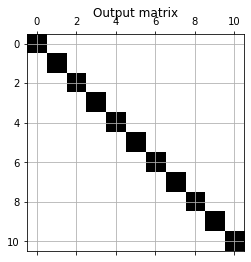

In [ ]:
import matplotlib.pyplot as plt

plt.spy(Ak, precision=1e-7)

plt.grid(True)

plt.title("Output matrix")
plt.show()

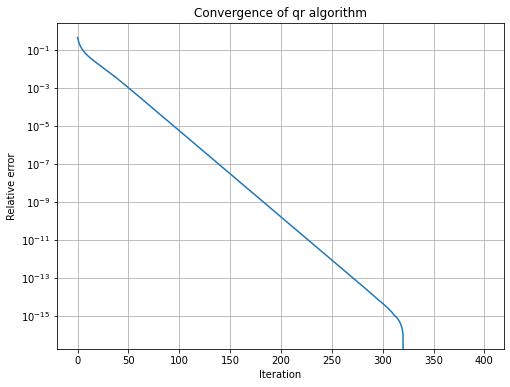

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.semilogy(list(range(400)), (convergence[-1] - convergence)/convergence[-1])

plt.grid(True)

plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.title("Convergence of qr algorithm")
plt.show()

#### Nonsymmetric case (4 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [ ]:
from scipy.sparse import diags

A = diags([5, 3, -2], [-1, 0, 1], shape=(11, 11)).toarray()

Ak, convergence = qr_algorithm(A, 250)

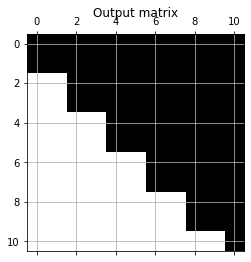

In [ ]:
import matplotlib.pyplot as plt

plt.spy(Ak, precision=1e-7)

plt.grid(True)

plt.title("Output matrix")
plt.show()

In [ ]:
abs(np.linalg.eigvals(A))

array([6.80591714, 6.80591714, 6.244998  , 6.244998  , 5.38516481,
       5.38516481, 3.41752717, 3.41752717, 3.        , 4.35889894,
       4.35889894])

Unfortunately, this matrix is not lower triangular. After computing true eigenvalues, we can see, that there is a gap between $\Lambda[:6]$ and $\Lambda[6:]$, therefore the covergence is lost and we have to use shifting in order to get the algorithm to work. 

## Problem 3. (Pseudo-Schur decomposition) 15 pts
Let's redefine scalar product $ \forall x, y \in \mathbb{C}^n$ in a following way:

$$ [x,y]_J = y^{*}Jx, \text{s.t.}\ J = \text{diag}(j_{11}, j_{22}, \dots, j_{nn})\ \text{and}\ j_{ii} = \pm1\ \forall i \in [1,n].$$

Denote rows of matrix $V \in \mathbb{C}^{n \times n}$ as $v_1, v_2, \dots, v_n$. Then $V$ is called $\textbf{J-orthonormal}$ iff 

$$[v_i, v_k]_J = \pm \delta_{ik}.$$

We will call matrix $T \in \mathbb{C}^{n \times n}$ $\textbf{almost triangular}$ iff $T$ is upper triangular with diagonal blocks of order $1$ or $2$.

Matrix $A \in \mathbb{C}^{n \times n}$ is said to be $\textbf{J-decomposable}$ if exist J-orthonormal matrix $V$ and upper triangular matrix $T$ such that 


$$A = V T V^{-1}.$$

Matrix $A \in \mathbb{C}^{n \times n}$ is said to have $\textbf{pseudoschur J-decomposition}$ if exist J-orthonormal matrix $V$ and almost triangular matrix $T$ such that


$$A = V T V^{-1}.$$

This problem is to get familiar with the fact that two abovementioned decompositions exist not for any square matrix with complex entries.




- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix} v_1 & v_2 &  \ldots & v_n \end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$. 



- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.


- (8 pts) Given that $A \in \mathbb{C}^{n \times n}$ is diagonalizable, show that it has pseudoschur J-decomposition for any $J$ of form $J=\text{diag}(\pm 1, \dots, \pm 1)$.
Note that in order to solve that subproblem you should firstly prove the following fact:

Let $S \in \mathbb{C}^{m \times n},\ m \ge n,\ J = \text{diag}(\pm 1).$ If $A = S^{*}JS$ and $det(A) \ne 0$, then exists QR decomposition of $S$ with respect to $J$: 
    $$S = P_1 QR P_2^{*} = P_1 Q \begin{bmatrix} R_1 \\ 0 \end{bmatrix} P_2^{*}, \ Q^{*} J^{'}Q = J^{'}, \ J^{'} = P_1^{*}JP_1,$$ where $P_1$ and $P_2$ are permutation matrices, $Q$ is called $J^{'}$- unitary and $R_1$ is almost triangular.


## 1.
To rephrase the task, we need to show that the first block of $T$ is of order 2.


$AV = VT$, then 

$[Av_1 Av_2 ... Av_n] = [v_1 v_2 ... v_n] T$

$Av_1 = v_1 [T_{11}, T_{12}]$

Now, if $T_{12}$ is equal to zero, $v_1$ would just be scaled by a constant which would be $T_{11}$ and it would be

$Av_1 = T_{11} v_1$, which would mean that $v_1$ is an eigenvector of $A$, but it isn't. Therefore, $T_{12}$ is not $0$.

## 2.

Let $A = [v_1, v_2] \times T \times [v_1, v_2]^{-1}$

In order for $v_2^* J v_1 = 0$ to be true, we need this inequality to hold:

$+-\frac{1}{v_{11}-v_{12}} \neq v_2^*$

## Problem 4. (Skeleton decomposition) 28 pts

The application that we are particularly interested in is
the approximation of a given matrix by a low-rank matrix:

$$ A \approx UV^T, A \in \mathbb{R}^{m \times n}, U \in \mathbb{R}^{m \times r}, V \in \mathbb{R}^{n \times r}.$$

It is well known that the best (in any unitary invariant norm) low-rank approximation can be computed via singular value decomposition (SVD). As an alternative, we can consider skeleton decompostion of the form:

$$A \approx A_r = A(: , \mathcal{J})A(\mathcal{I} , \mathcal{J})^{-1}A(\mathcal{I} , :),$$
where $\mathcal{I,J}$ are some index sets of length $r$.

Below we consider the matrix $N \times N$ derived from the following function discretization in the uniform grid in square $[0, 1] \times [0, 1]$:
$ f(x, y) = \exp(-\sqrt{x^2 + y^2})$.
It means that $A = [a_{ij}]$, where $a_{ij} = f(x_i, x_j)$ and $x_i = i / (N-1)$, $x_j = j / (N-1)$, where $i, j = 0,\ldots, N-1$.

- (2 pts) compose this matrix for $N = 5000$ without loops (Hint: function ```np.meshgrid``` can help you)


## 1.

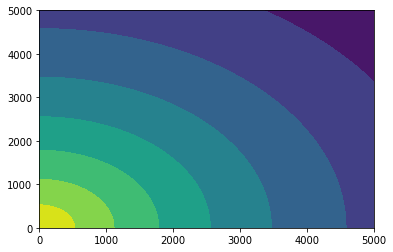

In [554]:
import numpy as np 
import matplotlib.pyplot as plt
N = 5000

x = np.linspace(0, N, N)
y = np.linspace(0, N, N)
xx, yy = np.meshgrid(x/(N-1), y/(N-1))
z = np.exp(-np.sqrt(xx ** 2 + yy ** 2))
h = plt.contourf(x,y,z)
plt.show()

- (3 pts) Compute Skeleton approximation with random selection of rows and columns indices for $r = 5$ (check that submatrix in the intersection of rows and columns is nonsingular). Average the relative error $\frac{\|A - A_r \|_F}{\|A\|_F}$ over $M$ samples of column/row indices. Check that $M$ is sufficiently large to provide stable mean.

 Note: extracting submatrices should be done according to ```numpy```  e.g. ```A[index_set, :]``` to extract selected rows, ```A[:, index_set]``` to extract selected columns etc..


## 2.

In [555]:
def skeleton_samples(A, r, n_samples, det_threshold=1e-100): # det_threshold is determinant border between singular and non-singular
    errors = []
    n_iterated = 0
    while n_iterated < n_samples:
        L0 = np.random.choice(A.shape[0] - 1, r)
        J0 = np.random.choice(A.shape[0] - 1, r)
        A_hat = A[L0, :][:, J0]
        A_hat_det = np.linalg.det(A_hat)

        if np.linalg.det(A_hat) <= det_threshold:
            continue # considered singular -> skip

        inv_A_hat = np.linalg.inv(A[L0, :][:, J0])
        Ar = A[:, J0] @ inv_A_hat @ A[L0,:]
        error = np.linalg.norm(A - Ar, ord='fro')/np.linalg.norm(A, ord='fro')
        errors.append(error)
        del Ar
        del inv_A_hat 
        n_iterated += 1
    return np.array(errors)

In [556]:
samples = skeleton_samples(z, 5, 200)

In [557]:
np.mean(samples)

0.12237521659994778

The error seems large. But random picking is rarely a good idea for a stable algorithm, so no wonder. Let's discover further.

As you should know from the lecture, if $A$ is of rank $r$ and $\hat{A} = A(\mathcal{I} , \mathcal{J})$ is nonsingular, then the exact equality holds. In the approximate case, however, the quality of the approximation depends on the volume of the submatrix $\hat{A}$: 

**Theorem**

*If $\hat{A} = A_{max}$ has maximal in modulus determinant among all $r \times r$ submatrices of $A$, the following error etimate holds:*

$$ \|A - A_r\|_1 \leq (r+1)\sigma_{r+1}.$$


And the question is how to choose a good submatrix of nearly maximal volume in practice.

**Definition**: *We call $r \times r$ submatrix $A_{dom}$ of rectangular $n \times r$ matrix $A$ of
full rank dominant, if all the entries of $AA_{dom}^{-1}$ are not greater than $1$ in
modulus.*

The crucial theoretical result behind the scene is that the volume of any dominant submatrix $A_{dom}$ can not be very much smaller than the maximum volume submatrix $A_{max}$ (without proof).

We provide the following algorithm for constructing dominant submatrix of a tall matrix.

**Algorithm 1**: 
    
Given matrix $A$ of size $n \times r$ finds dominant submatrix of size $r \times r$

1. Start with arbitrary nonsingular $r \times r$ submatrix $A_{dom}$. Reorder rows in $A$ so that $A_{dom}$ occupies first $r$ rows in $A$.

2. Compute $B = AA_{dom}^{-1}$ and find its maximum in module  entry $b_{ij}$.

3. **If $|b_{ij}| > 1 + \delta$, then**:

    Swap rows $i$ and $j$ in $B$ (accrodignly in A). By swapping the rows we have increased the volume of the upper submatrix in $B$, as well as in $A$ (why?). Let $A_{dom}$ be the new upper submatrix of $A$ and go to __step 1__.

    **elseif $|b_{ij}| < 1 + \delta$**:
    
    return $A_{dom}$.

Note: $\delta = 10^{-2}$ seems to be a good practical choice.

- (10 pts) Implement algorithm 1 according to the following signature, where the function returns ```row_indices``` array which can be used as ```A[row_indices, :]``` to extract selected submatrix.

Note that matrix inverse $A_{dom}^{-1}$ in step 3 has to be updated efficiently using [Shermann-Morison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) (inverse of rank-1 update).

In [616]:
def dominant_submatrix_search(A, delta=0.01, max_iter=5000):
    A = A.copy()
    A_initial = A.copy()
    r = min(A.shape)
    Adom = A[:r, :]
    Adom_inv = np.linalg.inv(Adom)
    i = 0
    while True:
        if i > max_iter:
            return 0
        B = A @ Adom_inv
        b_max = abs(B).max()
        if b_max > 1 + delta:
            i, j = np.unravel_index(np.argmax(abs(B), axis=None), B.shape)     
            u = np.zeros(r)
            u[j] = 1
            v = A[i, :] - A[j, :]

            B[[i,j]] = B[[j,i]]
            A[[i,j]] = A[[j,i]]

            Adom_inv = Adom_inv - (Adom_inv @ np.outer(u, v.T) @ Adom_inv) / (1 + v.T @ Adom_inv @ u)
            Adom = A[:r, :]
            i += 1
        else:
            row_indices = []
            for i in range(Adom.shape[0]):
                for j in range(A_initial.shape[0]):
                    if (A_initial[j] == Adom[i]).all():
                        row_indices.append(j)
                        continue
            
            return np.array(row_indices)

In [469]:
A = np.random.rand(5000, 10)

In [470]:
# check the convergence of your implementation on random data
row = dominant_submatrix_search(A)

In [471]:
row

[0, 3745, 3417, 4161, 3964, 709, 4523, 4415, 1311, 4042]

In [472]:
abs(A @ np.linalg.inv(A[row])).max() # it works, all values are only slightly more than 1

1.0000000000000002

- (10 pts) Propose the method to construct Skeleton approximation using Algorithm 1. The signature of the function is provided below.  Compare your algorithm with previously considered random selection on the matrix $A$.

Hint: 

1) start with random selection of columns 

2) if you transpose the matrix for which you find rows, then Algorithm 1 will give you update for columns in the initial matrix

In [605]:
def choose_columns(A, r):
  while True:
    columns = np.random.choice(A.shape[1] - 1, r)
    column_matrix = A[:, columns]
    rank = np.linalg.matrix_rank(column_matrix.T)
    if rank == r:
        break
  return column_matrix

In [624]:
def skeleton(A, r):
    column_matrix = choose_columns(A, r)
    basis_rows = dominant_submatrix_search(column_matrix)
    R = A[basis_rows, :]
    basis_cols = dominant_submatrix_search(R.T)

    print(basis_cols.shape, basis_rows.shape)

    return basis_rows, basis_cols

In [629]:
A = np.random.rand(15, 15)

In [630]:
for r in range(5, 15):
    rows, cols = skeleton(A, r)
    Ar = A[:, cols] @ np.linalg.inv(A[rows, :][:, cols]) @ A[rows, :]
    print(f"r = {r}, error = {np.linalg.norm(A - Ar, ord='fro')/np.linalg.norm(A, ord='fro')}")

(5,) (5,)
r = 5, error = 0.5001063249413307
(6,) (6,)
r = 6, error = 0.44894766888923066
(7,) (7,)
r = 7, error = 0.31378532161734435
(8,) (8,)
r = 8, error = 0.3443828452906633
(9,) (9,)
r = 9, error = 0.3007471400094385
(10,) (10,)
r = 10, error = 0.24449188275619593
(11,) (11,)
r = 11, error = 0.16824599684716038
(12,) (12,)
r = 12, error = 0.1559021472447601
(13,) (13,)
r = 13, error = 0.08080780452493176
(14,) (14,)
r = 14, error = 0.05460856493920317


We approximated $N = 5000$ with $r = 5$ and the error was two times bigger than approximating $15 \times 15$ matrix with $r = 14$. So we missteped somewhere. Tried to find some remedy [here](https://arxiv.org/pdf/1502.07838.pdf), but didn't manage to improve the algorithm.

- (3 pts) Compare your ```skeleton``` approximation algorithm with SVD and discuss its pros and cons.

In [633]:
%timeit np.linalg.svd(A)

The slowest run took 8.89 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 121 µs per loop


In [634]:
%timeit skeleton(A, 13)

(13,) (13,)
(13,) (13,)
(13,) (13,)
(13,) (13,)
The slowest run took 31.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 67.1 ms per loop


In [647]:
u, s, v = np.linalg.svd(A)

r = 13
u1 = u[:, :r]
s1 = s[:r]
v1 = v[:r, :]
a1 = u1.dot(np.diag(s1).dot(v1))
np.linalg.norm(A - a1, 'fro')/np.linalg.norm(A, 'fro')

0.024932314539841197

Well, seems like it's hard to compare my skeleton decomposition with SVD, because its error is quite high.